## 基于卷积自编码的图像去噪

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hiddenlayer as hl
from sklearn.model_selection import  train_test_split
from skimage.util import random_noise
from skimage.measure import compare_psnr


import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import STL10
from torchvision.utils import make_grid

使用STL10数据集来进行图像去噪分析

### 数据准备

10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

Images are 96x96 pixels, color.

5000 training images (10 pre-defined folds), 8000 test images per class.

100000 unlabeled images for unsupervised learning. 

因为使用STL10()函数来读取数据时需要下载2.5G的数据（约110000多张图像）。

为了节省时间和增加模型训练速度，我们只使用5000张图像来作为模型总的训练集和验证集。

将5000张图像重新进行数据切分，其中4000张用于训练，1000张作为验证集

In [3]:
## 定义一个将bin文件处理为图像数据的函数
def read_image(data_path):
    with open(data_path, 'rb') as f:
        data1 = np.fromfile(f, dtype=np.uint8)
        ## 图像[数量，通道，宽，高]
        images = np.reshape(data1, (-1, 3, 96, 96))
        ## 图像转化为RGB的形式，方便使用matplotlib进行可视化
        images = np.transpose(images, (0, 3, 2, 1))
    ## 输出的图像取值在0～1之间
    return images / 255.0

In [4]:
## 读取训练数据集,5000张96*96*3的图像
data_path = "data/STL10/stl10_binary/train_X.bin"
images = read_image(data_path)
print("images.shape:",images.shape)

images.shape: (5000, 96, 96, 3)


In [5]:
## 为数据添加高斯噪声
def gaussian_noise(images,sigma):  
    """sigma:噪声标准差"""
    sigma2 = sigma**2 / (255**2)  ## 噪声方差
    images_noisy = np.zeros_like(images)
    for ii in range(images.shape[0]):
        image = images[ii]
        ## 使用skimage库中的random_noise函数添加噪声
        noise_im = random_noise(image,mode="gaussian", var=sigma2,clip=True)
        images_noisy[ii] = noise_im
    return images_noisy
images_noise = gaussian_noise(images,30)
print("images_noise:",images_noise.min(),"~",images_noise.max())

images_noise: 0.0 ~ 1.0


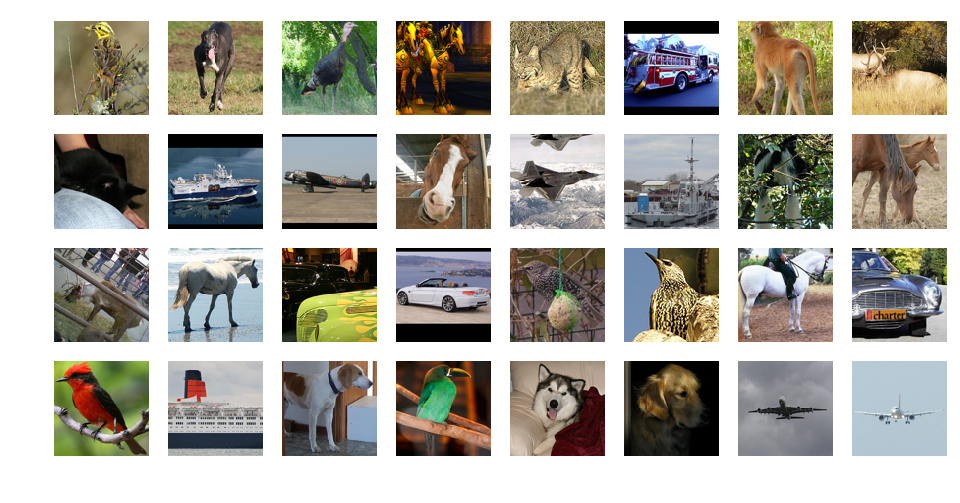

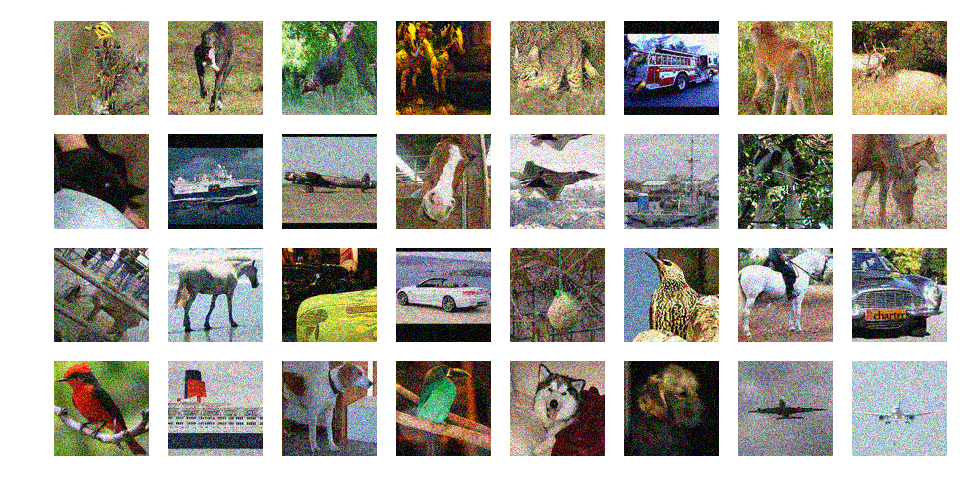

In [6]:
## 可视化其中的部分图像
## 不带噪声的图像
plt.figure(figsize=(8,4))
for ii in np.arange(32):
    plt.subplot(4,8,ii+1)
    plt.imshow(images[ii,...])
    plt.axis("off")
plt.show()
## 带噪声的图像
plt.figure(figsize=(8,4))
for ii in np.arange(32):
    plt.subplot(4,8,ii+1)
    plt.imshow(images_noise[ii,...])
    plt.axis("off")
plt.show()

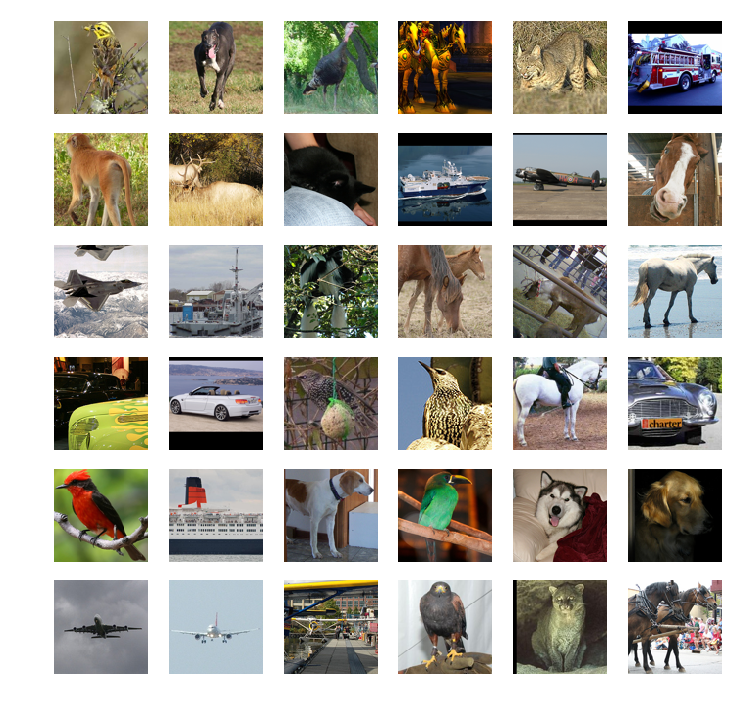

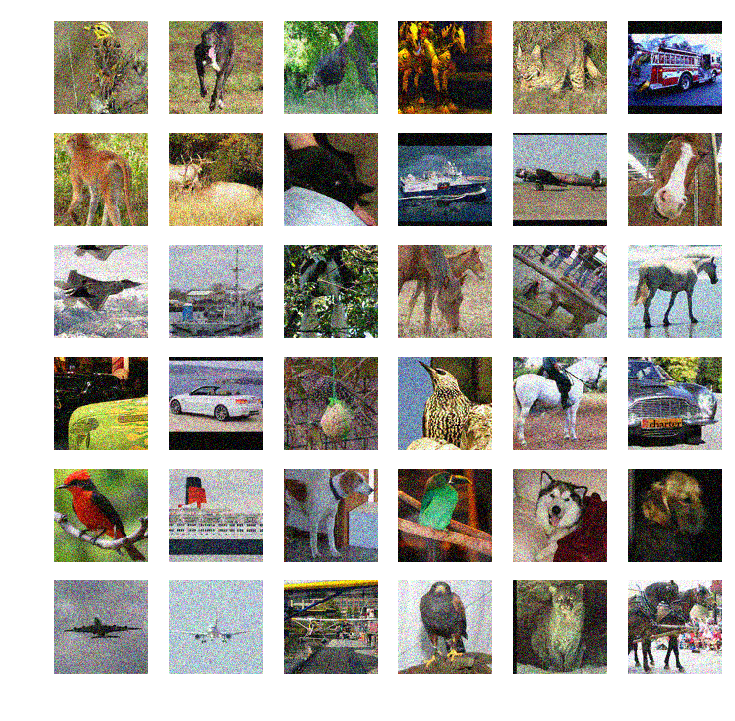

In [7]:
## 可视化其中的部分图像
## 不带噪声的图像
plt.figure(figsize=(6,6))
for ii in np.arange(36):
    plt.subplot(6,6,ii+1)
    plt.imshow(images[ii,...])
    plt.axis("off")
plt.show()
## 带噪声的图像
plt.figure(figsize=(6,6))
for ii in np.arange(36):
    plt.subplot(6,6,ii+1)
    plt.imshow(images_noise[ii,...])
    plt.axis("off")
plt.show()

In [8]:
## 数据准备为Pytorch可用的形式
## 转化为［样本，通道，高，宽］的数据形式
data_Y = np.transpose(images, (0, 3, 2, 1))
data_X = np.transpose(images_noise, (0, 3, 2, 1))
## 将数据集切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    data_X,data_Y,test_size = 0.2,random_state = 123)
## 将图像数据转化为向量数据
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
## 将X和Y转化为数据集合
train_data = Data.TensorDataset(X_train,y_train)
val_data = Data.TensorDataset(X_val,y_val)

print("X_train.shape:",X_train.shape)
print("y_train.shape:",y_train.shape)
print("X_val.shape:",X_val.shape)
print("y_val.shape:",y_val.shape)

X_train.shape: torch.Size([4000, 3, 96, 96])
y_train.shape: torch.Size([4000, 3, 96, 96])
X_val.shape: torch.Size([1000, 3, 96, 96])
y_val.shape: torch.Size([1000, 3, 96, 96])


In [9]:
print("X_train.shape:",X_train.shape)
print("y_train.shape:",y_train.shape)
print("X_val.shape:",X_val.shape)
print("y_val.shape:",y_val.shape)

X_train.shape: torch.Size([4000, 3, 96, 96])
y_train.shape: torch.Size([4000, 3, 96, 96])
X_val.shape: torch.Size([1000, 3, 96, 96])
y_val.shape: torch.Size([1000, 3, 96, 96])


In [10]:
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=32, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 4, # 使用4个进程 
)

## 定义一个数据加载器
val_loader = Data.DataLoader(
    dataset = val_data, ## 使用的数据集
    batch_size=32, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 4, # 使用4个进程 
)

for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)


torch.Size([32, 3, 96, 96])
torch.Size([32, 3, 96, 96])


### 模型1:通过转置卷积进行解码

In [12]:
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoEncoder,self).__init__()
        ## 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,
                      kernel_size = 3,stride=1,padding=1), # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1,1),# [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1,1),# [,64,96,96]
            nn.ReLU(),
            nn.MaxPool2d(2,2),# [,64,48,48]
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64,128,3,1,1),# [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,1,1),# [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1),# [,256,48,48]
            nn.ReLU(),
            nn.MaxPool2d(2,2),# [,256,24,24]
            nn.BatchNorm2d(256),
        )
        ## 定义Decoder
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,1,1), # [,128,24,24]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,128,3,2,1,1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128,64,3,1,1), # [,64,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,3,1,1), # [,32,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32,32,3,1,1), # [,32,48,48]
            nn.ConvTranspose2d(32,16,3,2,1,1), # [,16,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.ConvTranspose2d(16,3,3,1,1), # [,3,96,96]
            nn.Sigmoid(),
        )

    ## 定义网络的向前传播路径   
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder,decoder
    
## 输出我们的网络结构
DAEmodel = DenoiseAutoEncoder()
print(DAEmodel)

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

$ H_{out} = (H_{in} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0]
                + \text{kernel\_size}[0] + \text{output\_padding}[0]$ 

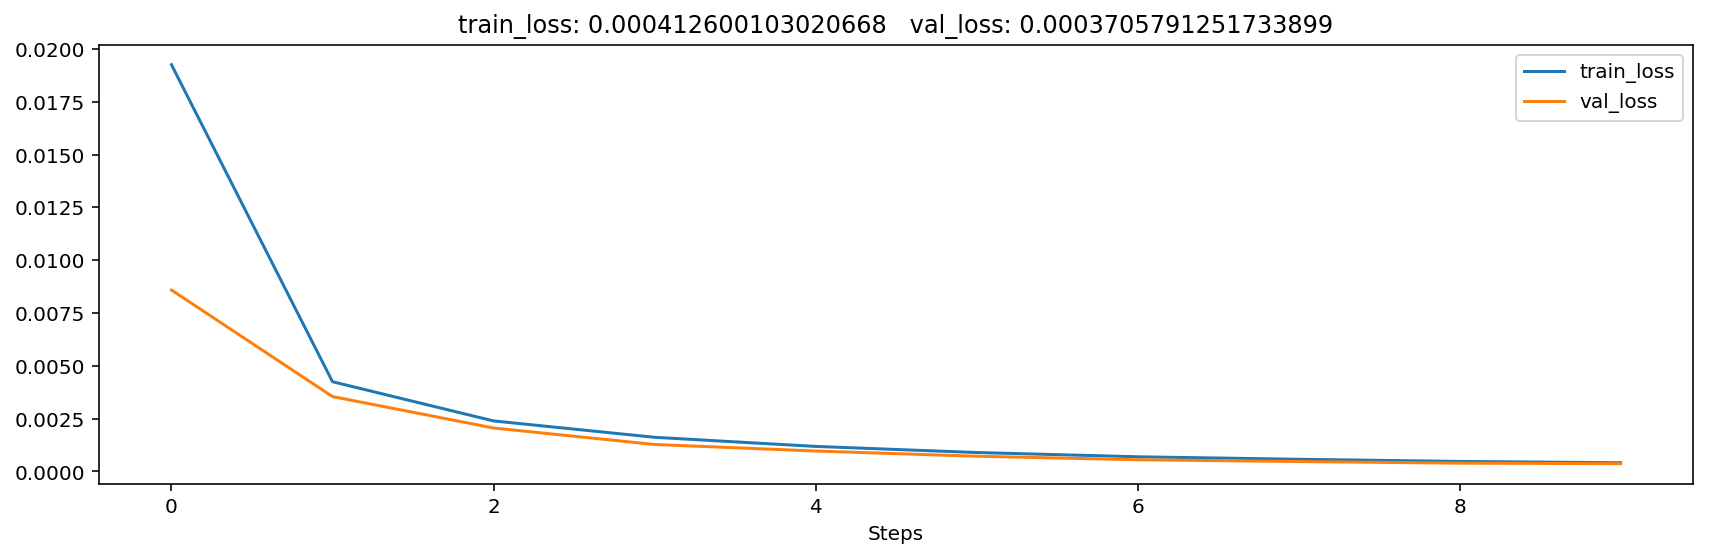

In [13]:
# 定义优化器
LR = 0.0003
optimizer = torch.optim.Adam(DAEmodel.parameters(), lr=LR)  
loss_func = nn.MSELoss()   # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
train_num = 0
val_num = 0
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x,b_y) in enumerate(train_loader): 
        DAEmodel.train()
        ## 使用每个batch进行训练模型
        _,output = DAEmodel(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 平方根误差
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num+b_x.size(0)
    
    ## 使用每个batch进行验证模型
    for step, (b_x,b_y) in enumerate(val_loader): 
        DAEmodel.eval()        
        _,output = DAEmodel(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 平方根误差
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num = val_num+b_x.size(0)
    ## 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    val_loss = val_loss_epoch / val_num
    
    ## 保存每个epoch上的输出loss
    history1.log(epoch,train_loss=train_loss,
                 val_loss = val_loss)
    # 可视网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"],history1["val_loss"]])


In [14]:
## 保存模型
# torch.save(DAEmodel,"data/chap8/DAEmodel_1.pkl")

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DenoiseAutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
# ## 导入保存的模型
DAEmodel = torch.load("data/chap8/DAEmodel_1.pkl")
DAEmodel

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

### 使用验证集中的一张图像查看去噪效果


加噪后的PSNR: 19.4783327304 dB
去噪后的PSNR: 25.1766086425 dB


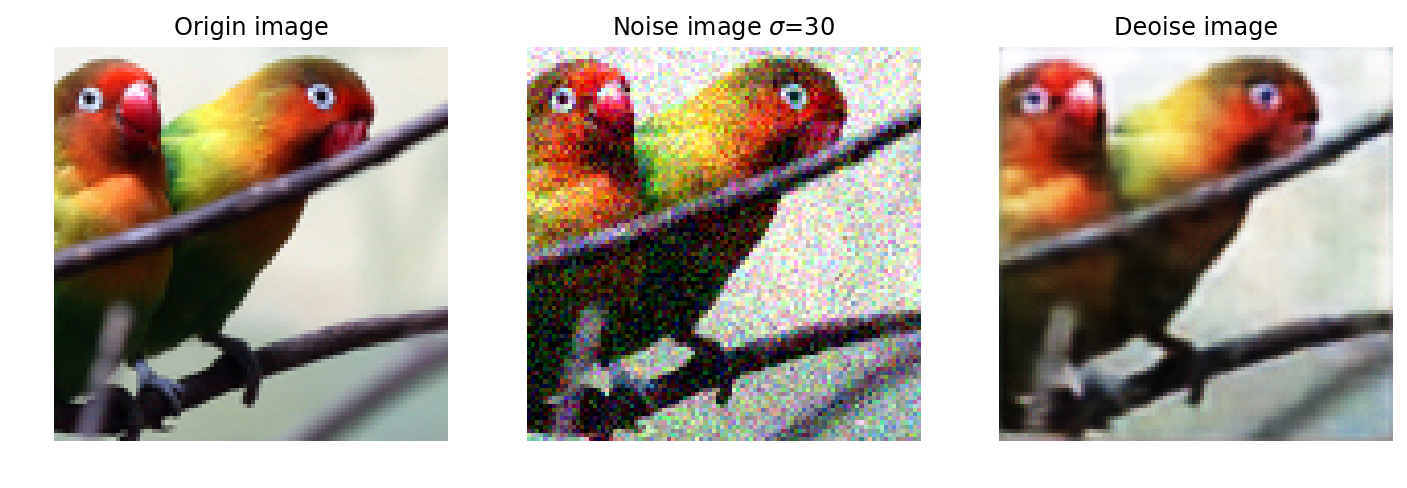

In [16]:
## 输入
imageindex = 1
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(),(0,3,2,1))
imnose = imnose[0,...]
## 去噪
DAEmodel.eval()        
_,output = DAEmodel(im)  
imde = np.transpose(output.data.numpy(),(0,3,2,1))
imde = imde[0,...]
## 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(),(0,3,2,1))
imor = imor[0,...]
## 计算去噪后的PSNR
print("加噪后的PSNR:",compare_psnr(imor,imnose),"dB")
print("去噪后的PSNR:",compare_psnr(imor,imde),"dB")

## 将图像可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")
plt.subplot(1,3,2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")
plt.subplot(1,3,3)
plt.imshow(imde)
plt.axis("off")
plt.title("Deoise image")
plt.show()

加噪后的PSNR: 18.5501766954 dB
去噪后的PSNR: 29.1882100191 dB


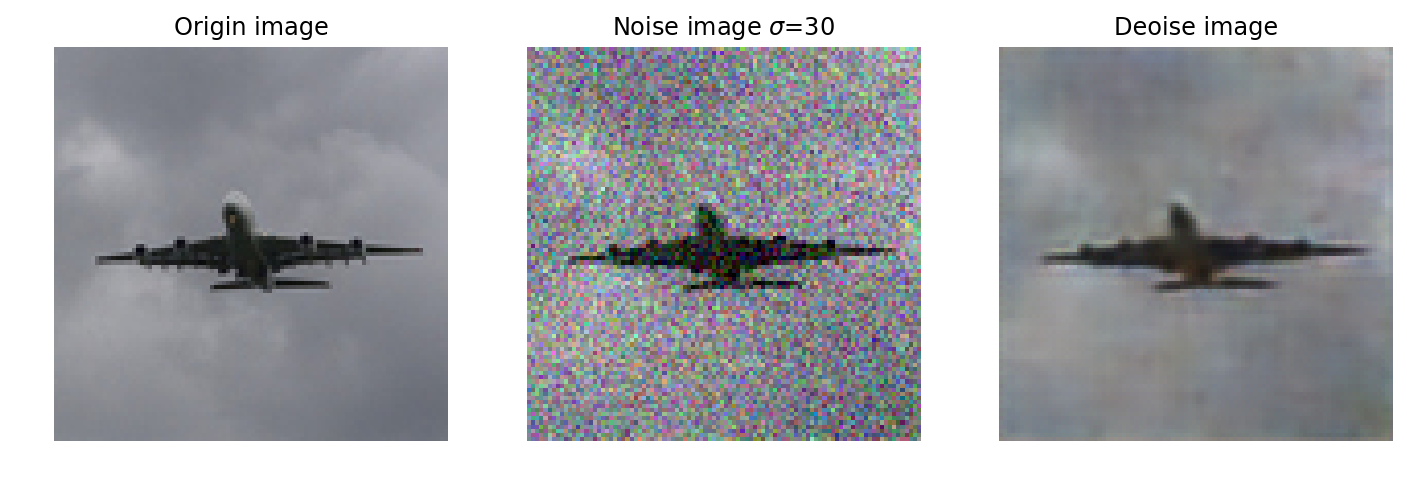

In [17]:
## 输入
imageindex = 6
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(),(0,3,2,1))
imnose = imnose[0,...]
## 去噪
DAEmodel.eval()        
_,output = DAEmodel(im)  
imde = np.transpose(output.data.numpy(),(0,3,2,1))
imde = imde[0,...]
## 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(),(0,3,2,1))
imor = imor[0,...]
## 计算去噪后的PSNR
print("加噪后的PSNR:",compare_psnr(imor,imnose),"dB")
print("去噪后的PSNR:",compare_psnr(imor,imde),"dB")

## 将图像可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")
plt.subplot(1,3,2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")
plt.subplot(1,3,3)
plt.imshow(imde)
plt.axis("off")
plt.title("Deoise image")
plt.show()

In [18]:
## 计算模型对整个验证集去噪后的PSNR提升量的均值
PSNR_val = []
DAEmodel.eval() 
for ii in range(X_val.shape[0]):
    imageindex = ii
    ## 输入
    im = X_val[imageindex,...]
    im = im.unsqueeze(0)
    imnose = np.transpose(im.data.numpy(),(0,3,2,1))
    imnose = imnose[0,...]
    ## 去噪       
    _,output = DAEmodel(im)  
    imde = np.transpose(output.data.numpy(),(0,3,2,1))
    imde = imde[0,...]
    ## 输出
    im = y_val[imageindex,...]
    imor = im.unsqueeze(0)
    imor = np.transpose(imor.data.numpy(),(0,3,2,1))
    imor = imor[0,...]
    ## 计算去噪后的PSNR
    PSNR_val.append(compare_psnr(imor,imde) - compare_psnr(imor,imnose))
    
print("PSNR的平均提升量为:",np.mean(PSNR_val),"dB")


PSNR的平均提升量为: 5.56174253303 dB


### 模型2使用UpsamplingBilinear2d()线性插值和卷积层进行Decoder

In [28]:
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoEncoder,self).__init__()
        ## 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,
                      kernel_size = 3,stride=1,padding=1), # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1,1),# [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1,1),# [,64,96,96]
            nn.ReLU(),
            nn.MaxPool2d(2,2),# [,64,48,48]
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64,128,3,1,1),# [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,1,1),# [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1),# [,256,48,48]
            nn.ReLU(),
            nn.MaxPool2d(2,2),# [,256,24,24]
            nn.BatchNorm2d(256),
        )
        ## 定义Decoder
        self.Decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2), # [,256,48,48]
            nn.Conv2d(256,128,3,1,1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,64,3,1,1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.UpsamplingBilinear2d(scale_factor=2), # [,64,96,96]
            nn.Conv2d(64,32,3,1,1), # [,32,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32,3,3,1,1), # [,3,96,96]
            nn.Sigmoid(),
        )

    ## 定义网络的向前传播路径   
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder,decoder
    
## 输出我们的网络结构
DAEmodel = DenoiseAutoEncoder()
print(DAEmodel)

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

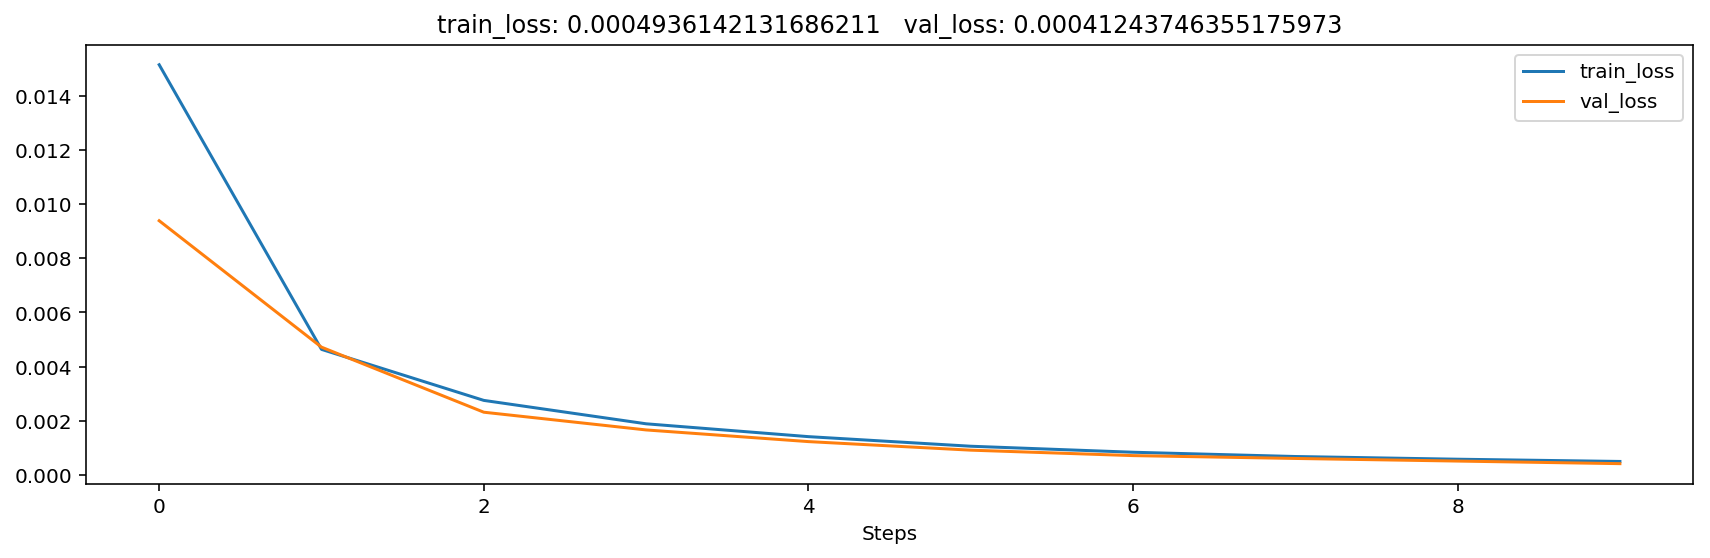

In [29]:
# 定义优化器
LR = 0.0003
optimizer = torch.optim.Adam(DAEmodel.parameters(), lr=LR)  
loss_func = nn.MSELoss()   # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
train_num = 0
val_num = 0
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x,b_y) in enumerate(train_loader): 
        DAEmodel.train()
        ## 使用每个batch进行训练模型
        _,output = DAEmodel(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 平方根误差
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num+b_x.size(0)
    
    ## 使用每个batch进行验证模型
    for step, (b_x,b_y) in enumerate(val_loader): 
        DAEmodel.eval()        
        _,output = DAEmodel(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 平方根误差
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num = val_num+b_x.size(0)
    ## 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    val_loss = val_loss_epoch / val_num
    
    ## 保存每个epoch上的输出loss
    history1.log(epoch,train_loss=train_loss,
                 val_loss = val_loss)
    # 可视网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"],history1["val_loss"]])


In [33]:
## 保存模型
torch.save(DAEmodel,"data/chap8/DAEmodel_2.pkl")
## 导入保存的模型
DAEmodel = torch.load("data/chap8/DAEmodel_2.pkl")
DAEmodel

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DenoiseAutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

加噪后的PSNR: 19.4783327304 dB
去噪后的PSNR: 23.8212045079 dB


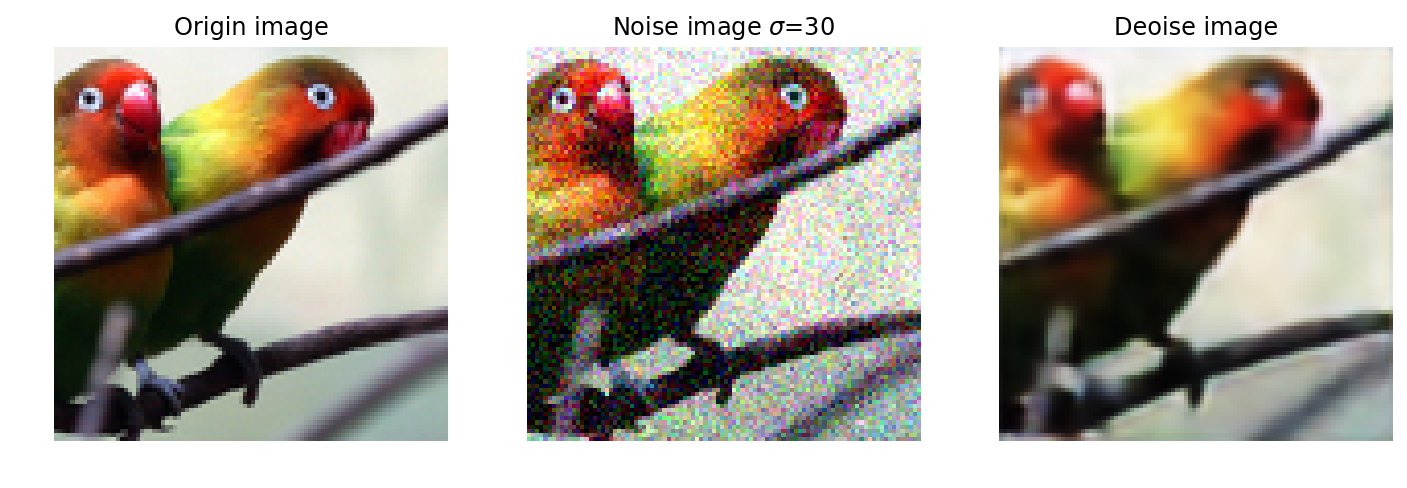

In [36]:
## 输入
imageindex = 1
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(),(0,3,2,1))
imnose = imnose[0,...]
## 去噪
DAEmodel.eval()        
_,output = DAEmodel(im)  
imde = np.transpose(output.data.numpy(),(0,3,2,1))
imde = imde[0,...]
## 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(),(0,3,2,1))
imor = imor[0,...]
## 计算去噪后的PSNR
print("加噪后的PSNR:",compare_psnr(imor,imnose),"dB")
print("去噪后的PSNR:",compare_psnr(imor,imde),"dB")

## 将图像可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")
plt.subplot(1,3,2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")
plt.subplot(1,3,3)
plt.imshow(imde)
plt.axis("off")
plt.title("Deoise image")
plt.show()

加噪后的PSNR: 18.5501766954 dB
去噪后的PSNR: 30.3693174845 dB


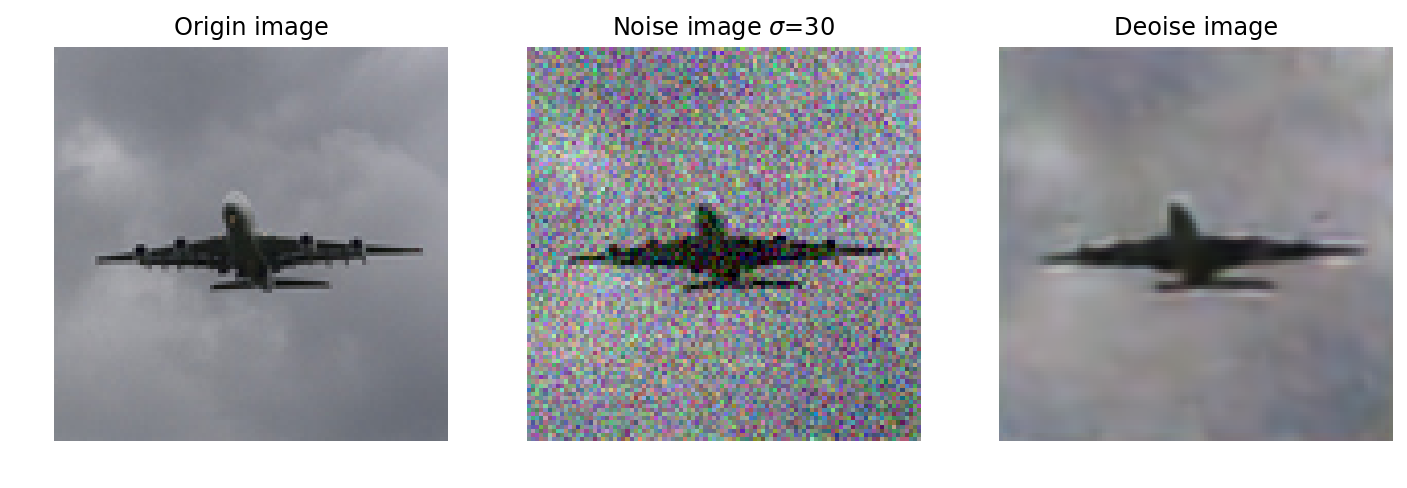

In [31]:
## 输入
imageindex = 6
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(),(0,3,2,1))
imnose = imnose[0,...]
## 去噪
DAEmodel.eval()        
_,output = DAEmodel(im)  
imde = np.transpose(output.data.numpy(),(0,3,2,1))
imde = imde[0,...]
## 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(),(0,3,2,1))
imor = imor[0,...]
## 计算去噪后的PSNR
print("加噪后的PSNR:",compare_psnr(imor,imnose),"dB")
print("去噪后的PSNR:",compare_psnr(imor,imde),"dB")

## 将图像可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")
plt.subplot(1,3,2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")
plt.subplot(1,3,3)
plt.imshow(imde)
plt.axis("off")
plt.title("Deoise image")
plt.show()

In [32]:
## 计算模型对整个验证集去噪后的PSNR提升量的均值
PSNR_val = []
DAEmodel.eval()
for ii in range(X_val.shape[0]):
    imageindex = ii
    ## 输入
    im = X_val[imageindex,...]
    im = im.unsqueeze(0)
    imnose = np.transpose(im.data.numpy(),(0,3,2,1))
    imnose = imnose[0,...]
    ## 去噪        
    _,output = DAEmodel(im)  
    imde = np.transpose(output.data.numpy(),(0,3,2,1))
    imde = imde[0,...]
    ## 输出
    im = y_val[imageindex,...]
    imor = im.unsqueeze(0)
    imor = np.transpose(imor.data.numpy(),(0,3,2,1))
    imor = imor[0,...]
    ## 计算去噪后的PSNR
    PSNR_val.append(compare_psnr(imor,imde) - compare_psnr(imor,imnose))
    
print("PSNR的平均提升量为:",np.mean(PSNR_val),"dB")


PSNR的平均提升量为: 5.28178280136 dB
